# Notebook de referência

Nome: Leandro Carísio Fernandes

## Instruções:


Treinar e medir a acurácia de um modelo BERT (ou variantes) para classificação binária usando o dataset do IMDB (20k/5k amostras de treino/validação).

Importante:
- Deve-se implementar o próprio laço de treinamento.
- Implementar o acumulo de gradiente.

Dicas:
- BERT geralmente costuma aprender bem uma tarefa com poucas épocas (de 3 a 5 épocas). Se tiver demorando mais de 5 épocas para chegar em 80% de acurácia, ajuste os hiperparametros.

- Solução para erro de memória:
  - Usar bfloat16 permite quase dobrar o batch size

Opcional:
- Pode-se usar a função trainer da biblioteca Transformers/HuggingFace para verificar se seu laço de treinamento está correto. Note que ainda assim é obrigatório implementar o laço próprio.

# Preparação

## Parâmetros

Sobre o modelo DistilBert: "It has 40% less parameters than google-bert/bert-base-uncased, runs 60% faster while preserving over 95% of BERT's performances as measured on the GLUE language understanding benchmark."

BATCH_SIZE:

- DistilBERT e L4: 64
- DistilBERT e T4: 32
- BERT-Base e L4: 32

In [ ]:
# MODEL_NAME = "bert-base-uncased" # Muito pesado
MODEL_NAME = 'distilbert/distilbert-base-uncased' # https://huggingface.co/docs/transformers/model_doc/distilbert
BATCH_SIZE = 64
LR = 5e-5
EPOCHS = 5

LOCAL_MODELO_DRIVE = '/content/drive/My Drive/IA024A-Redes_Neurais_NLP/Aula4-Analise_sentimentos_BERT/'
CARREGAR_MODELO_DO_DRIVE = True # Se setar pra True, ele vai carregar o modelo que está salvo na pasta acima e começar o fine-tuning a partir dele
SALVAR_NO_DRIVE = False # Se setar para True, vai salvar o modelo no drive

## Seed

In [ ]:
import random
import torch
import torch.nn.functional as F
import numpy as np

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Acesso ao drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalação de libs


In [ ]:
!pip install transformers -q

# Dados de treinamento, teste e validação

## Download

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz
!tar -xzf aclImdb.tgz

--2024-04-06 22:28:44--  http://files.fast.ai/data/aclImdb.tgz
Resolving files.fast.ai (files.fast.ai)... 172.67.69.159, 104.26.3.19, 104.26.2.19, ...
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/aclImdb.tgz [following]
--2024-04-06 22:28:44--  https://files.fast.ai/data/aclImdb.tgz
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145982645 (139M) [application/x-gtar-compressed]
Saving to: ‘aclImdb.tgz’

aclImdb.tgz         100%[===================>] 139.22M   145MB/s    in 1.0s    

2024-04-06 22:28:45 (145 MB/s) - ‘aclImdb.tgz’ saved [145982645/145982645]



## Separação em treino/validação/teste

Criaremos uma divisão de treino (20k exemplos) e validação (5k exemplos) artificialmente.

In [ ]:
import os

max_valid = 5000

def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('\n3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('\n3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('\n3 primeiras amostras validação:')
for x, y in zip(x_test[:3], y_test[:3]):    # No código original, estava x_valid
    print(y, x[:100])

print('\n3 últimas amostras validação:')
for x, y in zip(x_valid[-3:], y_valid[-3:]):
    print(y, x[:100])

20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.

3 primeiras amostras treino:
False This movie really deserves the MST3K treatment. A pseudo-ancient fantasy hack-n-slash tale featuring
False i tried to sit through this bomb not too long ago.what a disaster .the acting was atrocious.there we
True The story of Cinderella is one of my favorites from Charles Perrault, with Sleeping Beauty which was

3 últimas amostras treino:
False When great director/actor combinations are talked about the team of J. Lee Thompson and Charles Bron
True I disagree with previous comment about this movie. I think it was cute and fun and it carried a good
True With a well thought out cast, this movie was a great comedic relief. The plot is well-written and th

3 primeiras amostras validação:
True The 1970s opened the door to the largest, most diverse era of film in the history. Some films were g
True What attracts a man to military service? What prepares a man to survive br

## Dataframes (pandas) de treino/validação/teste

In [ ]:
import pandas as pd

df_train = pd.DataFrame({'x': x_train, 'y': y_train})
df_val = pd.DataFrame({'x': x_valid, 'y': y_valid})
df_test = pd.DataFrame({'x': x_test, 'y': y_test})

In [ ]:
print(df_train.head())
print(df_val.head())
print(df_test.head())

                                                   x      y
0  This movie really deserves the MST3K treatment...  False
1  i tried to sit through this bomb not too long ...  False
2  The story of Cinderella is one of my favorites...   True
3  The romance of the movie, which is also its ma...   True
4  Let me first state that while I have viewed ev...   True
                                                   x      y
0  Steve Carell has made a career out of portrayi...   True
1  Trawling through the Sci Fi weeklies section o...   True
2  After a lively if predictable opening bank-hei...  False
3  James Bishop (Matt Stasi) goes to a `mental il...  False
4  It's a really cheesy parody of Tomb Raider and...  False
                                                   x     y
0  The 1970s opened the door to the largest, most...  True
1  What attracts a man to military service? What ...  True
2  Leslie Carbaga's excellent book on the Fleishe...  True
3  A widely unknown strange little western w

Checando a distribuição de exemplos positivos e negativos nos dataframes:

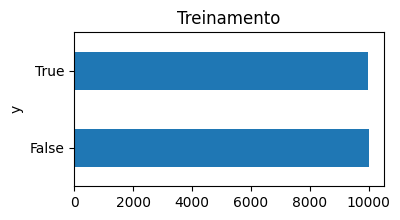

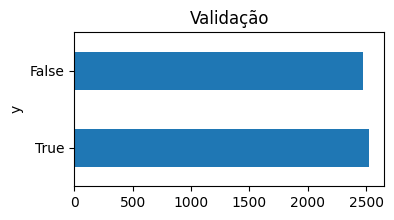

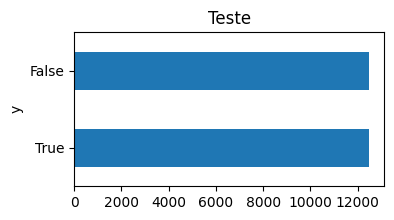

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,2))
df_train['y'].value_counts().plot.barh()
plt.title('Treinamento')
plt.show()

plt.figure(figsize=(4,2))
df_val['y'].value_counts().plot.barh()
plt.title('Validação')
plt.show()

plt.figure(figsize=(4,2))
df_test['y'].value_counts().plot.barh()
plt.title('Teste')
plt.show()


# Definição da classe Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from typing import List

class ImdbDataset(Dataset):
  def __init__(self, tokenizer, texts: List[str], labels: List[bool], max_seq_length: int = 512) -> None:
    self.max_seq_length = max_seq_length
    self.tokenizer = tokenizer
    self.texts = texts
    # Converte a lista de boolean para inteiros (True = 1, False = 0)
    self.labels = None if labels is None else [int(label) for label in labels]

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    batch_encoding = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, return_tensors="pt", max_length=self.max_seq_length)
    # O retorno de batch_encoding será:
    # {
    #    'input_ids':
    #    'token_type_ids' # (O BERT tem, mas o DistilBERT não tem)
    #    'attention_mask'
    # }

    # Além disso, precisamos colocar o 'labels' nele
    # Como o tokenizer irá retornar o input_ids e as outras propriedades
    # sempre numa lista, vamos fazer o mesmo com o labels
    if self.labels is not None:
      if isinstance(idx, int):
        batch_encoding['labels'] = torch.tensor([self.labels[idx]])
      elif isinstance(idx, slice):
        batch_encoding['labels'] = torch.tensor(self.labels[idx])

    # Observação: o dataloader, mesmo configurado pra batch_size, acessa
    # usando índices (e não slice). Nesse caso, tem que remover a dimensão
    # extra. Caso contrário, o batch['input_ids'].shape será algo como
    # torch.Size([32, 1, 512]). Entretanto, queremos apenas
    # torch.Size([32, 512])

    batch_encoding = { k: v.squeeze() for k, v in batch_encoding.items() }

    return batch_encoding

# Inicialização do modelo e tokenizador

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertTokenizer, BertForSequenceClassification

def carregar_modelo_e_tokenizador():
  #return BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device), BertTokenizer.from_pretrained(MODEL_NAME)
  str_modelo = LOCAL_MODELO_DRIVE if CARREGAR_MODELO_DO_DRIVE else MODEL_NAME
  return AutoModelForSequenceClassification.from_pretrained(str_modelo, num_labels=2).to(device), AutoTokenizer.from_pretrained(str_modelo)

model, tokenizer = carregar_modelo_e_tokenizador()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Algumas características do tokenizador:

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
tokenizer.model_max_length

1000000000000000019884624838656

## Instanciação Dataset e Dataloaders

In [ ]:
max_seq_length = 512 if tokenizer.model_max_length > 512 else tokenizer.model_max_length
dataset_train = ImdbDataset(tokenizer, x_train, y_train, max_seq_length)
dataset_val = ImdbDataset(tokenizer, x_valid, y_valid, max_seq_length)
dataset_test = ImdbDataset(tokenizer, x_test, y_test, max_seq_length)

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

## Função para avaliar a acurácia do treino

In [ ]:
from tqdm.auto import tqdm
from statistics import mean

def evaluate(model, dataloader, set_name = ''):
  print(f'****************** Avaliando: {set_name} **********************')
  losses = []
  correct = 0
  model.eval()
  with torch.no_grad():
    for batch in tqdm(dataloader, mininterval=0.5, desc=set_name, disable=False):
      # Coloca os tensores no device correto
      batch = { k: v.to(device) for k, v in batch.items() }

      outputs = model(**batch)
      loss_val = outputs.loss
      losses.append(loss_val.cpu().item())
      preds = outputs.logits.argmax(dim=1)
      # Tanto preds quanto batch['labels'] são tensores. Isso
      # vai fazer uma comparação elemento a elemento.
      correct += (preds == batch['labels']).sum().item()

  print(f'{set_name} loss: {mean(losses):0.3f}; {set_name} accuracy: {correct / len(dataloader.dataset):0.3f}')
  print(f'***************************************************************')

# Treino do modelo

Antes de iniciar o modelo, checa no conjunto de validação se a acurácia está aleatória (o modelo não foi treinado ainda, o esperado é que esteja bem balenceado de acordo com as classes - nesse caso, ~50%).

In [ ]:
evaluate(model, dataloader_val, 'Validação')

****************** Avaliando: Validação **********************


Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Validação loss: 0.695; Validação accuracy: 0.463
***************************************************************


Funções para salvar e recuperar o modelo:

In [ ]:
# Funções para salvar e recuperar o modelo. São usadas durante e após o treinamento
def salvar_modelo_no_drive(model, tokenizer):
  model.save_pretrained(LOCAL_MODELO_DRIVE)
  tokenizer.save_pretrained(LOCAL_MODELO_DRIVE)
  print('Modelo salvo')

def salva_modelo_arquivo_local(epoca):
    checkpoint_path = f"modelo_epoca_{epoca}.pth"
    torch.save({
        'epoch': epoca,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)

def recupera_modelo_arquivo_local(model, epoca):
  # Recupera o modelo salvo na época x
  checkpoint_path = f"modelo_epoca_{epoca}.pth"
  # Carregar o estado do checkpoint
  checkpoint = torch.load(checkpoint_path)
  # Aplicar o estado do modelo e otimizador carregados
  model.load_state_dict(checkpoint['model_state_dict'])

Função para treinar o modelo:

In [ ]:
from transformers import get_linear_schedule_with_warmup

def treina_modelo(model, optimizer, dataloader_train, dataloader_val, epochs = EPOCHS):
  # Isso é quantas vezes os pesos ajustados pelo loss.backward
  num_training_steps = epochs * len(dataloader_train)
  # Warm up is important to stabilize training.
  num_warmup_steps = int(num_training_steps * 0.1)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

  # Training loop
  for epoch in tqdm(range(epochs), desc='Epochs'):
    train_losses = []
    model.train()
    for batch in tqdm(dataloader_train, mininterval=0.5, desc='Train', disable=False):
      batch = { k: v.to(device) for k, v in batch.items() }
      outputs = model(**batch)
      loss = outputs.loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()

      train_losses.append(loss.cpu().item())

    if SALVAR_NO_DRIVE:
      salvar_modelo_no_drive(model, tokenizer)
    salva_modelo_arquivo_local(epoch+1)
    salvar_modelo_no_drive
    print(f'Época: {epoch + 1} Loss de treino: {mean(train_losses):0.2f}')
    evaluate(model=model, dataloader=dataloader_val, set_name='Validação')


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
treina_modelo(model, optimizer, dataloader_train, dataloader_val, EPOCHS)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Modelo salvo
Época: 1 Loss de treino: 0.32
****************** Avaliando: Validação **********************


Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Validação loss: 0.217; Validação accuracy: 0.914
***************************************************************


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Modelo salvo
Época: 2 Loss de treino: 0.15
****************** Avaliando: Validação **********************


Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Validação loss: 0.252; Validação accuracy: 0.912
***************************************************************


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Modelo salvo
Época: 3 Loss de treino: 0.07
****************** Avaliando: Validação **********************


Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Validação loss: 0.257; Validação accuracy: 0.916
***************************************************************


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Modelo salvo
Época: 4 Loss de treino: 0.03
****************** Avaliando: Validação **********************


Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Validação loss: 0.330; Validação accuracy: 0.919
***************************************************************


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Modelo salvo
Época: 5 Loss de treino: 0.01
****************** Avaliando: Validação **********************


Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Validação loss: 0.324; Validação accuracy: 0.925
***************************************************************


In [ ]:
if SALVAR_NO_DRIVE:
  melhor_epoca = 5
  recupera_modelo_arquivo_local(model, melhor_epoca)
  salvar_modelo_no_drive(model, tokenizer)

Modelo salvo


# Acurácia nas bases de treinamento, validação e testes

In [ ]:
evaluate(model=model, dataloader=dataloader_train, set_name='Treinamento')
evaluate(model=model, dataloader=dataloader_val, set_name='Validação')
evaluate(model=model, dataloader=dataloader_test, set_name='Teste')

****************** Avaliando: Treinamento **********************


Treinamento:   0%|          | 0/313 [00:00<?, ?it/s]

Treinamento loss: 0.009; Treinamento accuracy: 0.999
***************************************************************
****************** Avaliando: Validação **********************


Validação:   0%|          | 0/79 [00:00<?, ?it/s]

Validação loss: 0.324; Validação accuracy: 0.925
***************************************************************
****************** Avaliando: Teste **********************


Teste:   0%|          | 0/391 [00:00<?, ?it/s]

Teste loss: 0.289; Teste accuracy: 0.930
***************************************************************


# Testando pra um texto qualquer

In [ ]:
def print_indices(dataframe, indices):
  for idx in indices:
    texto = dataframe['x'][idx]
    esperado = dataframe['y'][idx]
    print(f'\n-------------- Teste índice {idx} --------------')
    input = tokenizer(texto, truncation=True, return_tensors="pt", max_length=512)
    input = { k: v.to(device) for k, v in input.items() }
    output = model(**input)
    pred = output.logits.argmax(dim=1)
    print(texto)
    print(f'Esperado: {esperado}')
    print(f'Estimado: {pred.item()}')

In [ ]:
# Alguns números na base de teste:
print_indices(df_test, list(range(0, 10)) + list(range(24500, 24510)))


-------------- Teste índice 0 --------------
The 1970s opened the door to the largest, most diverse era of film in the history. Some films were great ("The Godfather", "The Conversation", "Mean Streets", Chinatown", "The French Connection", "Five Easy Pieces", "Jaws", "McCabe And Mrs. Miller") Others were not so great ("The Getaway", "The Outfit", "Badge 373", "Joe", "The Taking Of Pelham One Two Three", "Brewster McCloud", "Castle Keep") And others were barely worth the price of admission.<br /><br />Yet every one was a fresh breath of air compared to today's Corporate Hollywood. Where every film is given a Big Weekend to recoup its cost. Or go straight to HBO and rental.<br /><br />What "Decade" does so well is to relate the sudden and rarely experienced sensation of freedom to be given money to make and direct a film. Perhaps personal. Perhaps not. Sometime with a clutch of extras. Sometimes, in the middle of a busy street before the cops show up. Long before the Corporate Overseer